# pycs Statistics Demonstration

This notebook demonstrates computing weak lensing summary statistics using the original **pycs** (CosmoStat) implementation.

We will:
1. Generate a mock convergence map
2. Compute wavelet peak counts and L1-norms using pycs
3. Visualize the results

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Import pycs libraries
from pycs.astro.wl.mass_mapping import *
from pycs.sparsity.sparse2d.starlet import *
from pycs.misc.cosmostat_init import *
from pycs.astro.wl.hos_peaks_l1 import *

print("✓ Imports successful")

✓ Imports successful


In [35]:
# Monkey patch for pycs + NumPy 2.x compatibility
# pycs uses deprecated np.lib.pad which was removed in NumPy 2.0
if not hasattr(np.lib, 'pad'):
    np.lib.pad = np.pad
    print("⚠️  Applied NumPy 2.x compatibility patch for pycs")

## 1. Configuration

In [36]:
# Map generation parameters
IMG_SIZE = 256             # 256x256 pixels per map
PIXEL_ARCMIN = 0.5         # Resolution in arcminutes

# Physics parameters
NOISE_LEVEL = 0.02         # Shape noise level
SIGNAL_AMPLITUDE = 0.03    # Typical peak amplitude
N_PEAKS_RANGE = (5, 15)    # Number of structures per map

# Statistics parameters
NSCALES = 5                # Wavelet scales
MIN_SNR = -2.0            # Minimum SNR for histograms
MAX_SNR = 6.0             # Maximum SNR for histograms
NBINS = 31                # Bins for peak histograms
NBINS_L1 = 40             # Bins for L1-norms
L1_MIN_SNR = -6.0        # Minimum SNR for L1-norm histograms
L1_MAX_SNR = 6.0         # Maximum SNR for L1-norm histograms

print("Configuration:")
print(f"  Map size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Wavelet scales: {NSCALES}")
print(f"  Noise level: {NOISE_LEVEL}")
print(f"\n✓ Configuration set")

Configuration:
  Map size: 256x256
  Wavelet scales: 5
  Noise level: 0.02

✓ Configuration set


## 2. Generate Mock Convergence Map

Create a realistic mock weak lensing convergence map with Gaussian structures.

In [37]:
def generate_mock_map(img_size, noise_level=0.02, signal_amplitude=0.03, seed=None):
    """
    Generate a mock convergence map with Gaussian structures.
    
    Parameters
    ----------
    img_size : int
        Size of square map (pixels)
    noise_level : float
        Standard deviation of shape noise
    signal_amplitude : float
        Typical amplitude of structures
    seed : int, optional
        Random seed for reproducibility
        
    Returns
    -------
    kappa_clean : np.ndarray
        Clean convergence map
    kappa_noisy : np.ndarray
        Noisy convergence map
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Start with weak Gaussian background
    kappa = np.random.randn(img_size, img_size) * 0.005
    
    # Add multiple Gaussian structures (peaks and troughs)
    n_structures = np.random.randint(*N_PEAKS_RANGE)
    
    for _ in range(n_structures):
        # Random position (avoid edges)
        x = np.random.randint(20, img_size-20)
        y = np.random.randint(20, img_size-20)
        
        # Random amplitude (can be positive or negative)
        amplitude = np.random.randn() * signal_amplitude
        
        # Random width
        sigma = np.random.randint(5, 15)
        
        # Create Gaussian structure
        xx, yy = np.meshgrid(
            np.arange(img_size),
            np.arange(img_size),
            indexing='ij'
        )
        gaussian = amplitude * np.exp(
            -((xx - x)**2 + (yy - y)**2) / (2 * sigma**2)
        )
        kappa += gaussian
    
    # Add shape noise
    noise = np.random.randn(img_size, img_size) * noise_level
    kappa_noisy = kappa + noise
    
    return kappa, kappa_noisy

print("✓ Map generation function defined")

✓ Map generation function defined


In [38]:
# Generate a mock map
print(f"Generating mock {IMG_SIZE}x{IMG_SIZE} convergence map...")
kappa_clean, kappa_noisy = generate_mock_map(
    IMG_SIZE, 
    noise_level=NOISE_LEVEL,
    signal_amplitude=SIGNAL_AMPLITUDE,
    seed=42
)

print(f"✓ Map generated")
print(f"  Shape: {kappa_noisy.shape}")
print(f"  Value range: [{kappa_clean.min():.3f}, {kappa_clean.max():.3f}]")

Generating mock 256x256 convergence map...
✓ Map generated
  Shape: (256, 256)
  Value range: [-0.058, 0.094]


### Visualize the Map

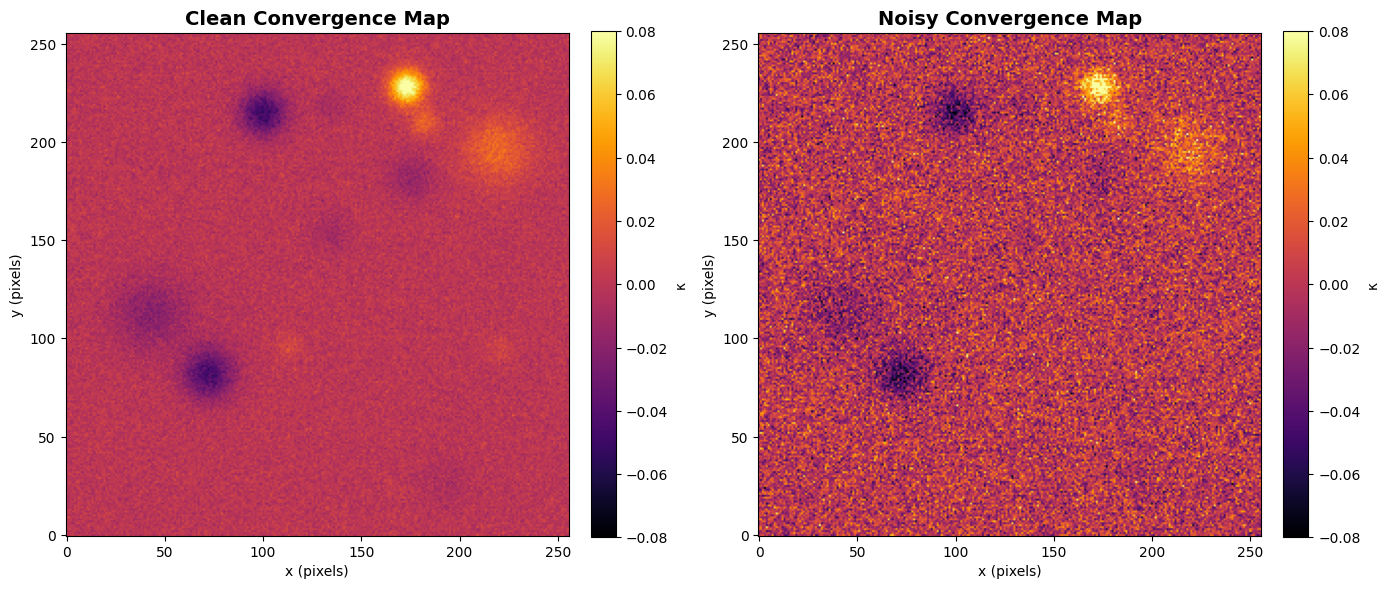

✓ Visualization complete


In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Clean map
im1 = ax1.imshow(kappa_clean, cmap='inferno', vmin=-0.08, vmax=0.08, origin='lower')
ax1.set_title('Clean Convergence Map', fontsize=14, fontweight='bold')
ax1.set_xlabel('x (pixels)')
ax1.set_ylabel('y (pixels)')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='κ')

# Noisy map
im2 = ax2.imshow(kappa_noisy, cmap='inferno', vmin=-0.08, vmax=0.08, origin='lower')
ax2.set_title('Noisy Convergence Map', fontsize=14, fontweight='bold')
ax2.set_xlabel('x (pixels)')
ax2.set_ylabel('y (pixels)')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label='κ')

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## 3. Define pycs Statistics Function

In [40]:
def summary_statistics(mass_map, sigma_noise, mask, nscales=NSCALES, 
                       min_snr=MIN_SNR, max_snr=MAX_SNR, nbins=NBINS, nbins_l1=NBINS_L1):
    """
    Computes summary statistics from a noisy kappa map using wavelet transforms.

    Parameters:
    -----------
    mass_map : np.ndarray
        (Noisy) kappa map.
    sigma_noise : float or np.ndarray
        Noise level in the kappa map.
    mask : np.ndarray
        Binary mask indicating the observational field.
    nscales : int
        Number of wavelet scales to use.
    min_snr, max_snr : float
        Minimum and maximum signal-to-noise ratios for peak detection.
    nbins : int
        Number of bins for histogramming peaks.
    nbins_l1 : int
        Number of bins for the L1-norm histogram.

    Returns:
    --------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        Arrays of the computed Mono_Peaks_Count, Peaks_Count, and l1norm.
    """
    nx, ny = mass_map.shape
    WT = starlet2d(gen2=False, l2norm=False, verb=False)
    WT.init_starlet(nx, ny, nscale=nscales)
    H = HOS_starlet_l1norm_peaks(WT)
    H.set_bins(Min=min_snr, Max=max_snr, nbins=nbins)
    H.set_data(mass_map, SigmaMap=sigma_noise)
    H.get_mono_scale_peaks(mass_map, sigma_noise)#, smoothing_sigma=0.01)
    H.get_wtpeaks()
    pc = H.Peaks_Count
    H.get_wtl1(nbins_l1*2, min_snr=-6, max_snr=6)

    return H.Mono_Peaks_Count, H.Peaks_Count, H.l1norm

print("✓ Statistics function defined")

✓ Statistics function defined


In [41]:
nx, ny = kappa_noisy.shape
WT = starlet2d(gen2=False, l2norm=False, verb=False)
WT.init_starlet(nx, ny, nscale=NSCALES)

In [42]:
sigma_noise_map = np.ones_like(kappa_noisy) * NOISE_LEVEL

In [43]:
wt_transf = WT.transform(kappa_noisy)


NoiseCoef = get_wt_noiselevel(WT, sigma_noise_map)
WSNR = get_snr_noiselevel(WT, kappa_noisy, NoiseCoef, KeepSign=True)

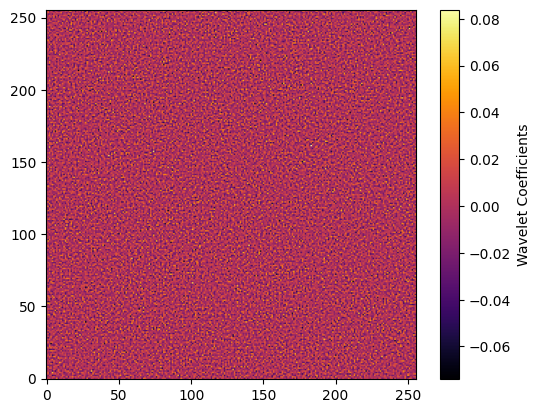

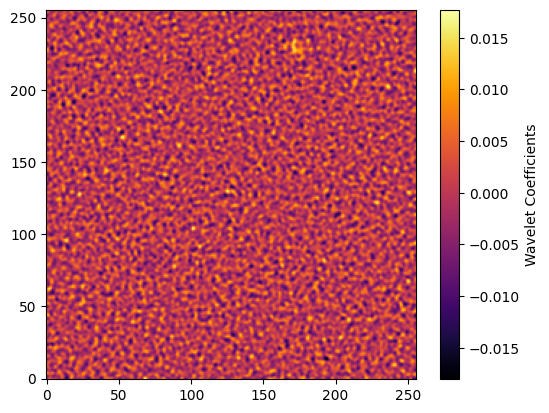

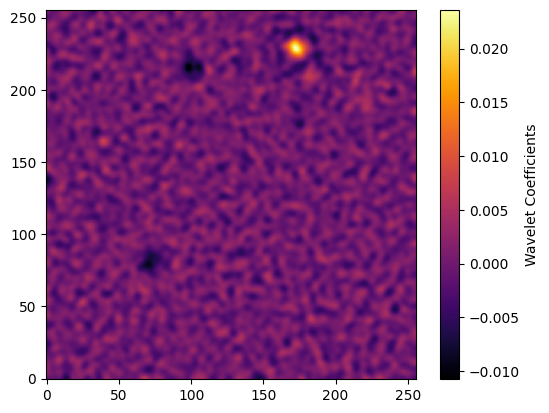

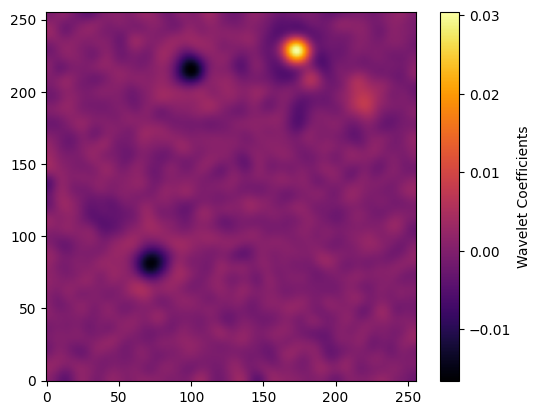

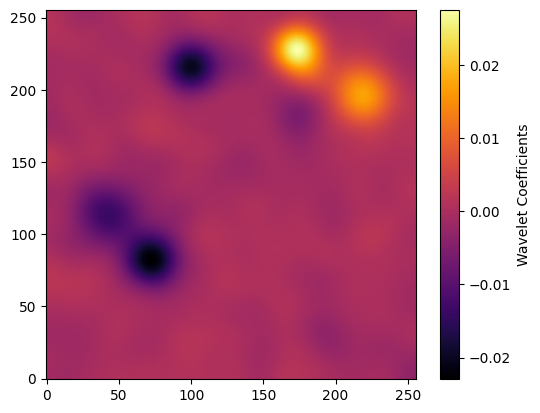

In [44]:
for i in range(5):
    plt.imshow(WT.coef[i], origin='lower', cmap='inferno')
    plt.colorbar(label='Wavelet Coefficients')
    plt.show()

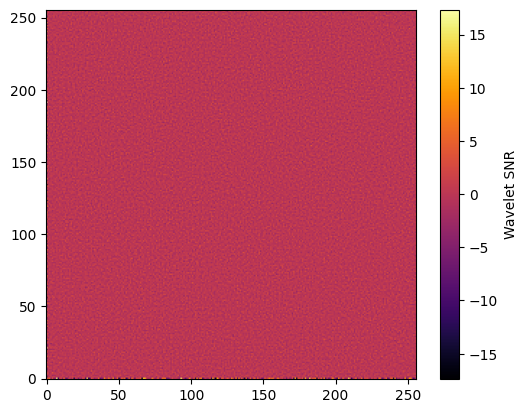

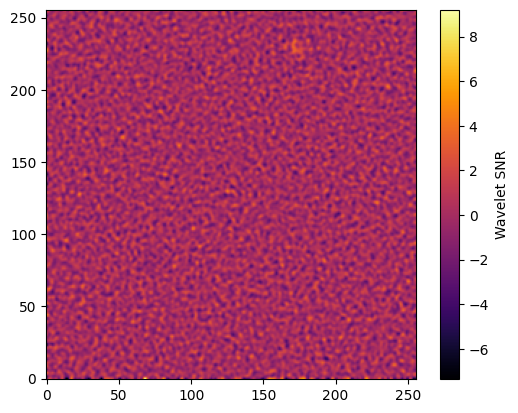

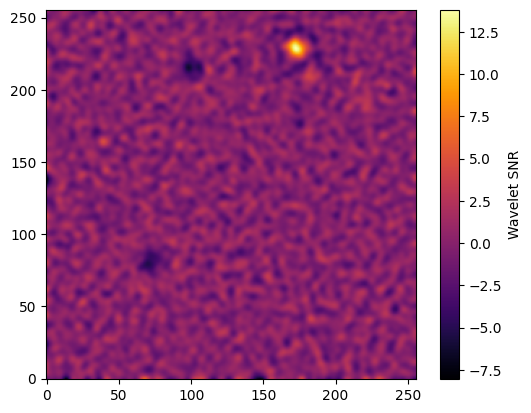

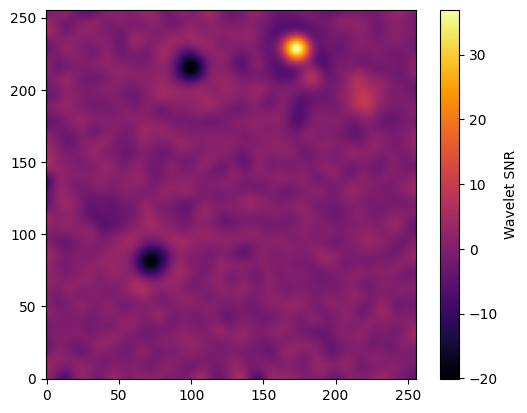

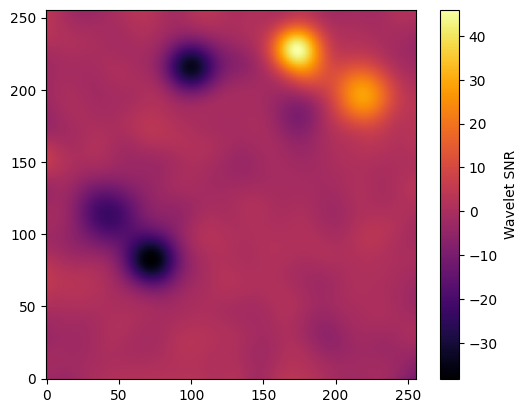

In [45]:
for i in range(5):
    plt.imshow(WSNR[i], origin='lower', cmap='inferno')
    plt.colorbar(label='Wavelet SNR')
    plt.show()

## 4. Compute Statistics with pycs

In [46]:
# Create mask (all ones = full coverage)
mask = np.ones((IMG_SIZE, IMG_SIZE))

print("Computing statistics with pycs...")
print(f"  Map size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Number of scales: {NSCALES}")
print(f"  SNR range: [{MIN_SNR}, {MAX_SNR}]")
print()

# Compute statistics
mono_peaks, peaks_count, l1norm = summary_statistics(
    kappa_noisy,
    sigma_noise_map,
    mask,
    nscales=NSCALES,
    min_snr=MIN_SNR,
    max_snr=MAX_SNR,
    nbins=NBINS+1,
    nbins_l1=NBINS_L1
)

print("✓ Statistics computed successfully")
print(f"\nResults:")
print(f"  Mono peaks shape: {mono_peaks.shape}")
# print(f"  Peak counts shape: {peaks_count.shape} ({NSCALES} scales)")
print(f"  L1 norms shape: {l1norm.shape} ({NSCALES} scales)")

Computing statistics with pycs...
  Map size: 256x256
  Number of scales: 5
  SNR range: [-2.0, 6.0]

✓ Statistics computed successfully

Results:
  Mono peaks shape: (31,)
  L1 norms shape: (5, 80) (5 scales)


## 5. Visualize Wavelet Peak Counts

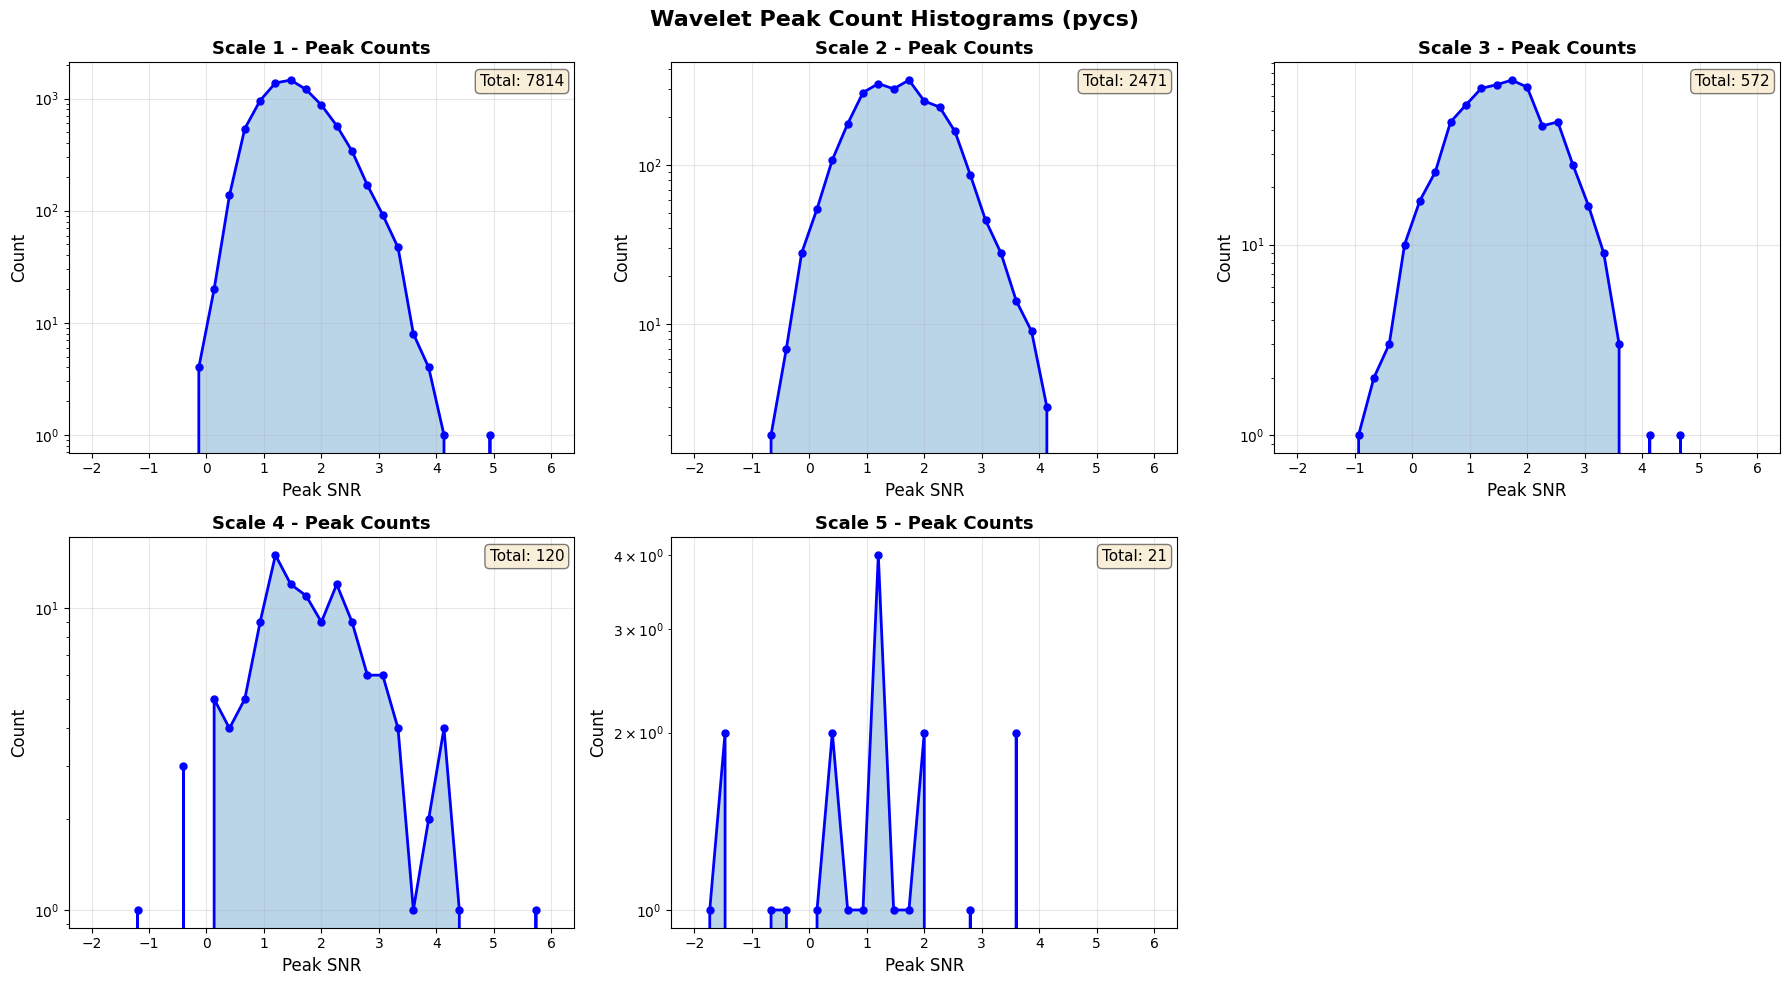

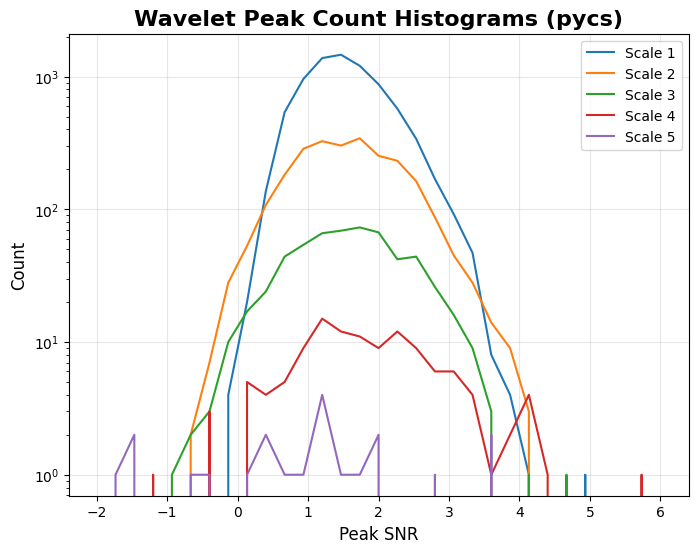

In [47]:
# Create bin centers for plotting
peak_bins = np.linspace(MIN_SNR, MAX_SNR, NBINS)

# Plot peak counts for all scales
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for scale in range(NSCALES):
    ax = axes[scale]
    
    # Plot peak histogram
    ax.plot(peak_bins, peaks_count[scale], 'b-', linewidth=2, marker='o', markersize=5)
    ax.fill_between(peak_bins, peaks_count[scale], alpha=0.3)
    
    ax.set_xlabel('Peak SNR', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Scale {scale+1} - Peak Counts', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Add total peak count
    total_peaks = np.sum(peaks_count[scale])
    ax.text(0.98, 0.97, f'Total: {int(total_peaks)}',
            transform=ax.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('Wavelet Peak Count Histograms (pycs)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for scale in range(NSCALES):
    plt.plot(
        peak_bins, peaks_count[scale], label=f'Scale {scale+1}'
    )
plt.xlabel('Peak SNR', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Wavelet Peak Count Histograms (pycs)', fontsize=16, fontweight='bold')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

## 6. Visualize L1-Norms

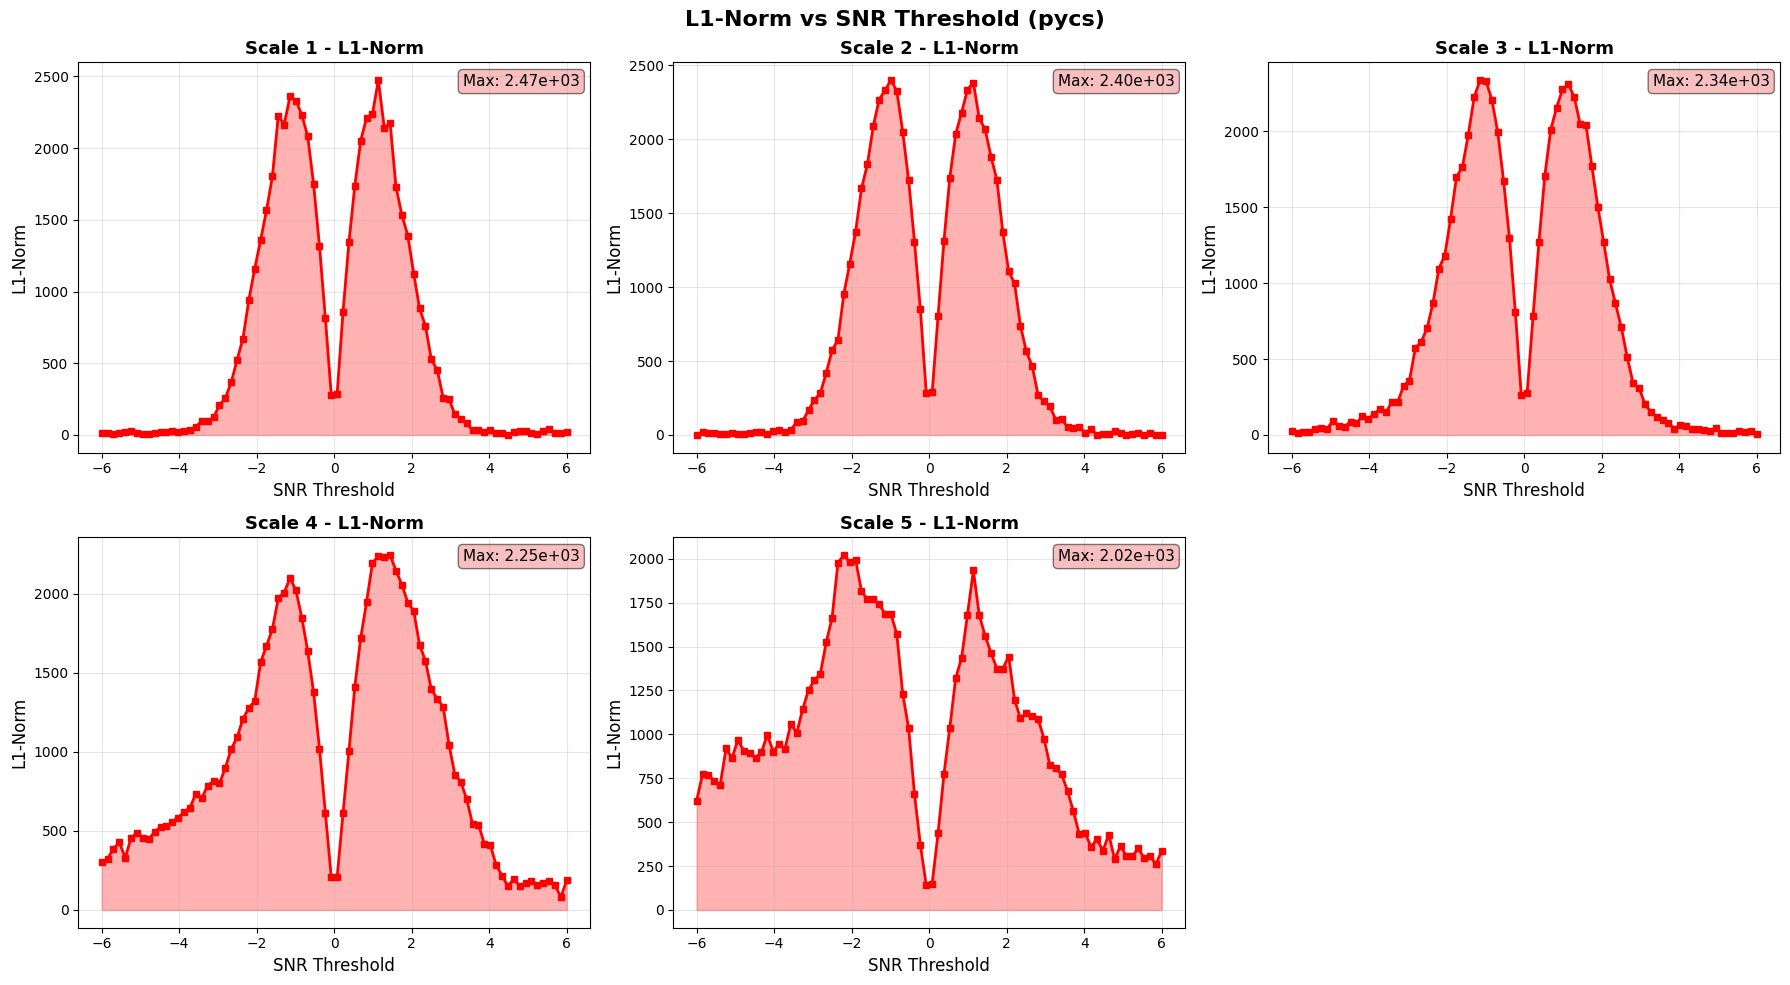

✓ L1-norm visualization complete


In [48]:
# Plot L1-norms for all scales
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for scale in range(NSCALES):
    ax = axes[scale]
    
    # L1-norm has its own binning from pycs
    n_l1_bins = len(l1norm[scale])
    l1_bins = np.linspace(-6, 6, n_l1_bins)  # pycs uses -6 to 6 range
    
    # Plot L1-norm
    ax.plot(l1_bins, l1norm[scale], 'r-', linewidth=2, marker='s', markersize=4)
    ax.fill_between(l1_bins, l1norm[scale], alpha=0.3, color='red')
    
    ax.set_xlabel('SNR Threshold', fontsize=12)
    ax.set_ylabel('L1-Norm', fontsize=12)
    ax.set_title(f'Scale {scale+1} - L1-Norm', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    # ax.set_yscale('log')  # Log scale to see details
    
    # Add max value
    max_l1 = np.max(l1norm[scale])
    ax.text(0.98, 0.97, f'Max: {max_l1:.2e}',
            transform=ax.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('L1-Norm vs SNR Threshold (pycs)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ L1-norm visualization complete")

## 7. Visualize Mono-Scale Peaks

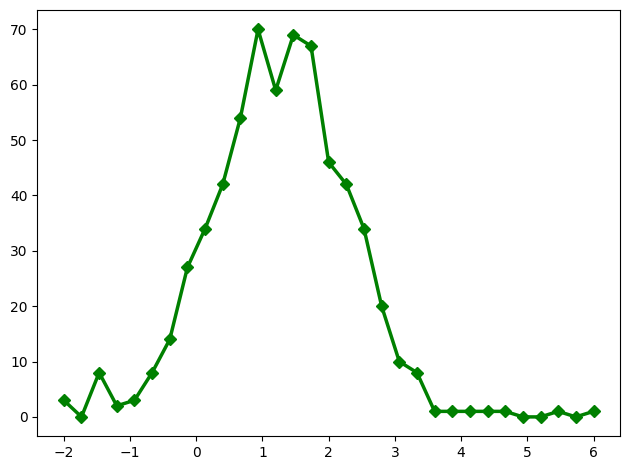

✓ Mono-scale peak visualization complete


In [49]:
# Plot mono-scale peak counts
fig, ax = plt.subplots()

ax.plot(peak_bins, mono_peaks, 'g-', linewidth=2.5, marker='D', markersize=6)

plt.tight_layout()
plt.show()

print("✓ Mono-scale peak visualization complete")

## 8. Summary Statistics

In [50]:
print("="*70)
print("SUMMARY STATISTICS (pycs)")
print("="*70)

print(f"\nMap Configuration:")
print(f"  Size: {IMG_SIZE}×{IMG_SIZE} pixels")
print(f"  Noise level: {NOISE_LEVEL}")
print(f"  Number of scales: {NSCALES}")

print(f"\nMono-Scale Peaks:")
print(f"  Total peaks detected: {int(np.sum(mono_peaks))}")
print(f"  Peak SNR range: [{peak_bins.min():.1f}, {peak_bins.max():.1f}]")

print(f"\nWavelet Peak Counts (by scale):")
for scale in range(NSCALES):
    total = int(np.sum(peaks_count[scale]))
    max_count = int(np.max(peaks_count[scale]))
    print(f"  Scale {scale+1}: {total:>6} peaks (max bin: {max_count})")

print(f"\nL1-Norms (by scale):")
for scale in range(NSCALES):
    max_l1 = np.max(l1norm[scale])
    min_l1 = np.min(l1norm[scale])
    print(f"  Scale {scale+1}: max={max_l1:.2e}, min={min_l1:.2e}")

print("\n" + "="*70)
print("✓ Statistics computation complete!")
print("="*70)

SUMMARY STATISTICS (pycs)

Map Configuration:
  Size: 256×256 pixels
  Noise level: 0.02
  Number of scales: 5

Mono-Scale Peaks:
  Total peaks detected: 627
  Peak SNR range: [-2.0, 6.0]

Wavelet Peak Counts (by scale):
  Scale 1:   7814 peaks (max bin: 1461)
  Scale 2:   2471 peaks (max bin: 343)
  Scale 3:    572 peaks (max bin: 73)
  Scale 4:    120 peaks (max bin: 15)
  Scale 5:     21 peaks (max bin: 4)

L1-Norms (by scale):
  Scale 1: max=2.47e+03, min=0.00e+00
  Scale 2: max=2.40e+03, min=0.00e+00
  Scale 3: max=2.34e+03, min=5.89e+00
  Scale 4: max=2.25e+03, min=8.08e+01
  Scale 5: max=2.02e+03, min=1.40e+02

✓ Statistics computation complete!


# Torch

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

from wl_stats_torch import WLStatistics
from wl_stats_torch.visualization import (
    plot_peak_histograms,
    plot_l1_norms,
    plot_wavelet_scales
)

In [52]:
# Initialize calculator
stats_calculator = WLStatistics(
    n_scales=NSCALES,
    pixel_arcmin=PIXEL_ARCMIN
)

print("WL Statistics Calculator initialized")
print(f"  Device: {stats_calculator.device}")
print(f"  Number of scales: {stats_calculator.n_scales}")
print(f"  Pixel resolution: {stats_calculator.pixel_arcmin} arcmin")

# Show scale resolutions
resolutions = stats_calculator.get_scale_resolutions()
print(f"\n  Scale resolutions (arcmin):")
for i, res in enumerate(resolutions):
    print(f"    Scale {i+1}: {res:.2f} arcmin")

print("\n✓ Calculator ready")

WL Statistics Calculator initialized
  Device: cuda
  Number of scales: 5
  Pixel resolution: 0.5 arcmin

  Scale resolutions (arcmin):
    Scale 1: 1.00 arcmin
    Scale 2: 2.00 arcmin
    Scale 3: 4.00 arcmin
    Scale 4: 8.00 arcmin
    Scale 5: 16.00 arcmin

✓ Calculator ready


In [53]:
# Map generation parameters
IMG_SIZE = 256             # 256x256 pixels per map
PIXEL_ARCMIN = 0.5         # Resolution in arcminutes

# Physics parameters
NOISE_LEVEL = 0.02         # Shape noise level
SIGNAL_AMPLITUDE = 0.03    # Typical peak amplitude
N_PEAKS_RANGE = (5, 15)    # Number of structures per map

# Statistics parameters
NSCALES = 5                # Wavelet scales
MIN_SNR = -2.0            # Minimum SNR for histograms
MAX_SNR = 6.0             # Maximum SNR for histograms
NBINS = 31                # Bins for peak histograms
NBINS_L1 = 40             # Bins for L1-norms

print("Configuration:")
print(f"  Map size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Wavelet scales: {NSCALES}")
print(f"  Noise level: {NOISE_LEVEL}")
print(f"\n✓ Configuration set")

Configuration:
  Map size: 256x256
  Wavelet scales: 5
  Noise level: 0.02

✓ Configuration set


In [54]:
kappa_noisy.shape

kapp_noisy_tensor = torch.tensor(
    kappa_noisy[np.newaxis, np.newaxis, :, :],
    dtype=torch.float32,
    device=stats_calculator.device
)

In [55]:
kapp_noisy_tensor[0][0]

tensor([[ 0.0004,  0.0078,  0.0203,  ..., -0.0225, -0.0462, -0.0242],
        [-0.0372, -0.0017, -0.0070,  ..., -0.0185,  0.0039,  0.0066],
        [-0.0137, -0.0229,  0.0153,  ..., -0.0059, -0.0131, -0.0240],
        ...,
        [-0.0062,  0.0307, -0.0021,  ..., -0.0185,  0.0013,  0.0268],
        [-0.0042,  0.0330, -0.0171,  ..., -0.0336, -0.0127, -0.0049],
        [ 0.0010,  0.0239, -0.0020,  ...,  0.0193, -0.0226,  0.0226]],
       device='cuda:0')

In [56]:
print("Processing single map with all statistics...")
start = time.time()

results = stats_calculator.compute_all_statistics(
    kapp_noisy_tensor[0][0],
    NOISE_LEVEL,
    min_snr=MIN_SNR,
    max_snr=MAX_SNR,
    l1_min_snr=L1_MIN_SNR,
    l1_max_snr=L1_MAX_SNR,
    n_bins=NBINS,
    l1_nbins=NBINS_L1,
    compute_mono=True,
    verbose=True
)

single_time = time.time() - start

print(f"\n✓ Single map processed in {single_time:.3f}s")
print(f"\nResults keys: {list(results.keys())}")

Processing single map with all statistics...
Computing wavelet transform...
Computing wavelet peak counts...
Scale 1: Min SNR = -19.8202, Max SNR = 17.2666
Scale 2: Min SNR = -6.9176, Max SNR = 7.2730
Scale 3: Min SNR = -8.6820, Max SNR = 13.8079
Scale 4: Min SNR = -20.1497, Max SNR = 36.9348
Scale 5: Min SNR = -38.2675, Max SNR = 45.9577
Computing wavelet L1-norms...
Computing mono-scale peaks...
✓ All statistics computed!

✓ Single map processed in 0.037s

Results keys: ['wavelet_coeffs', 'noise_levels', 'snr', 'peak_bins', 'wavelet_peak_counts', 'wavelet_peak_positions', 'wavelet_peak_heights', 'l1_bins', 'wavelet_l1_norms', 'mono_peak_bins', 'mono_peak_counts']


In [57]:
results['mono_peak_counts']

tensor([ 3.,  0.,  8.,  2.,  3.,  8., 14., 27., 34., 42., 53., 69., 60., 69.,
        65., 49., 44., 31., 21., 10.,  8.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
         1.,  0.,  1.], device='cuda:0')

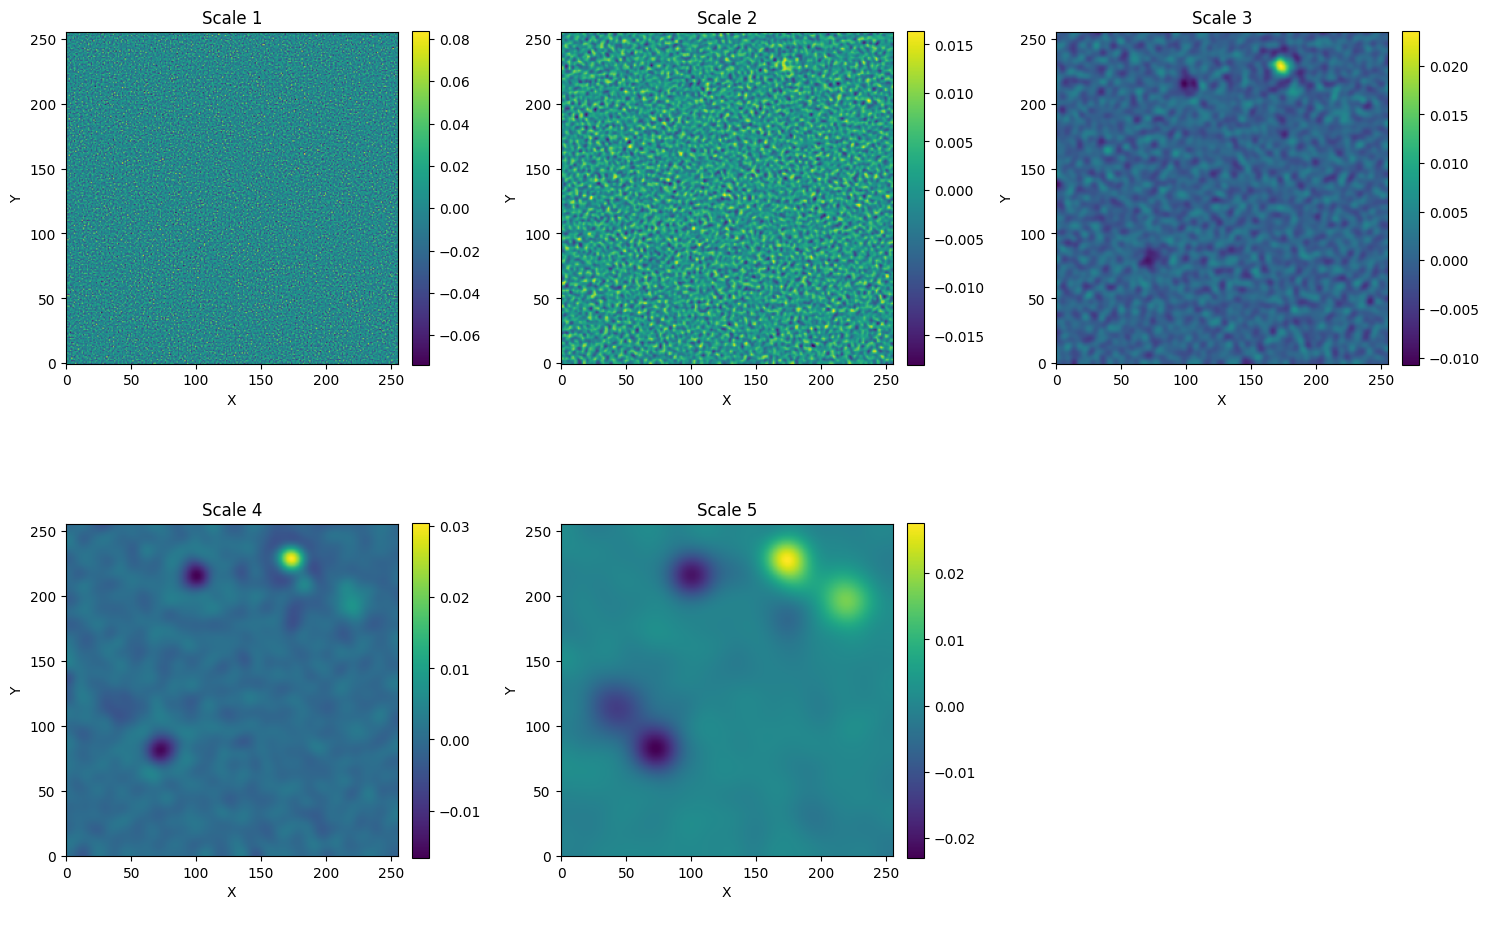

<Figure size 640x480 with 0 Axes>

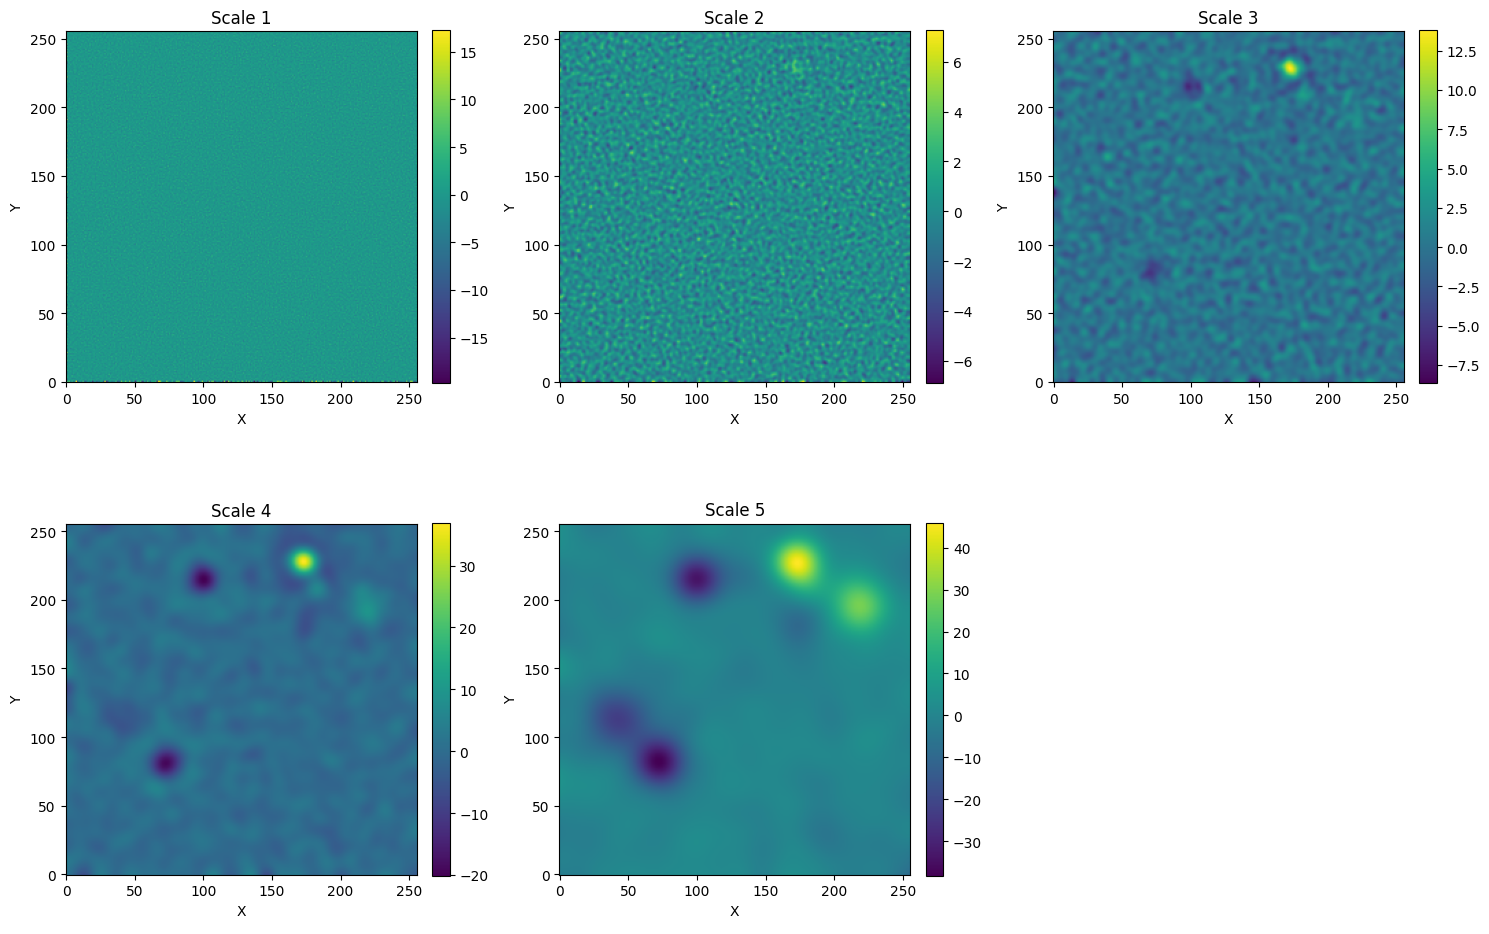

<Figure size 640x480 with 0 Axes>

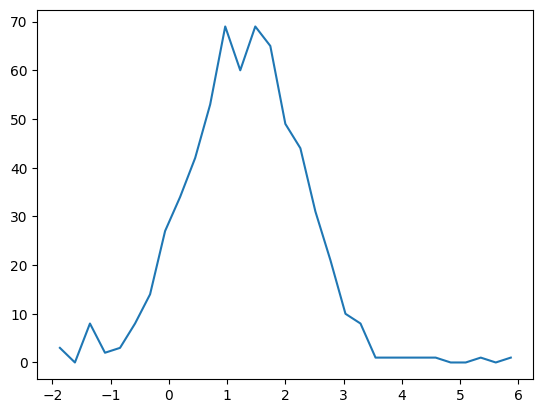

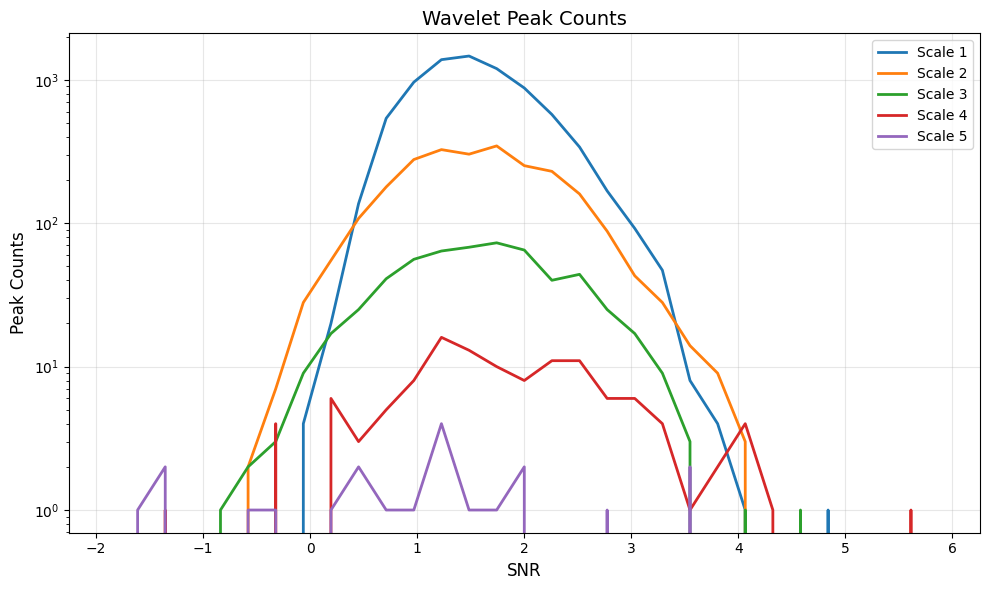

<Figure size 640x480 with 0 Axes>

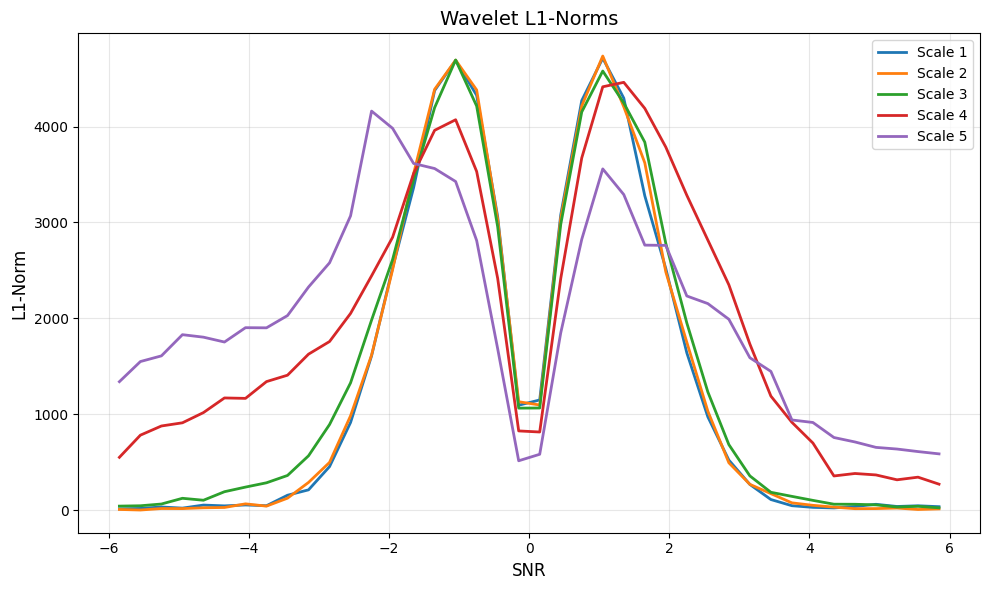

<Figure size 640x480 with 0 Axes>

✓ Visualizations complete


In [58]:
fig = plot_wavelet_scales(results['wavelet_coeffs'])
plt.suptitle('Wavelet Decomposition - Example Map', y=1.00)
plt.show()

fig = plot_wavelet_scales(results['snr'])
plt.suptitle('Wavelet Decomposition - Example Map', y=1.00)
plt.show()


plt.plot(results['peak_bins'].cpu(), results['mono_peak_counts'].cpu())
plt.show()

# Plot peak histograms
fig = plot_peak_histograms(
    results['peak_bins'],
    results['wavelet_peak_counts'],
    scale_labels=[f"Scale {i+1}" for i in range(NSCALES)]
)
plt.suptitle('Wavelet Peak Count Histograms', y=0.995)
plt.show()

# Plot L1-norms
fig = plot_l1_norms(
    results['l1_bins'],
    results['wavelet_l1_norms'],
    scale_labels=[f"Scale {i+1}" for i in range(NSCALES)]
)
plt.suptitle('L1-Norm vs SNR Threshold', y=0.995)
plt.show()

print("✓ Visualizations complete")

In [59]:
# results['l1_bins']
l1_bins_tensor_list = results['l1_bins']
l1_norms_tensor_list = results['wavelet_l1_norms']
# make the list of tensors into a tensor
l1_bins_tensor = torch.stack(l1_bins_tensor_list)
l1_norms_tensor = torch.stack(l1_norms_tensor_list)

In [60]:
l1_bins_array = l1_bins_tensor.cpu().numpy()
l1_norms_array = l1_norms_tensor.cpu().numpy()

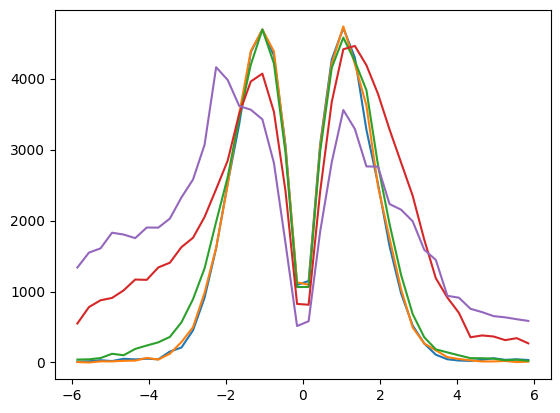

In [61]:
for i in range(NSCALES):
    plt.plot(
        l1_bins_array[i], l1_norms_array[i], label=f"Scale {i+1}"
    )
# plt.xlim(-2,3)
# plt.ylim(0, 4000)

In [62]:
l1_bins, l1_norms = stats_calculator.compute_wavelet_l1_norms(
    n_bins=80,
    min_snr=-6,
    max_snr=6
)

In [63]:
l1_bins_np = torch.stack(l1_bins).cpu().numpy()
l1_norms_np = torch.stack(l1_norms).cpu().numpy()

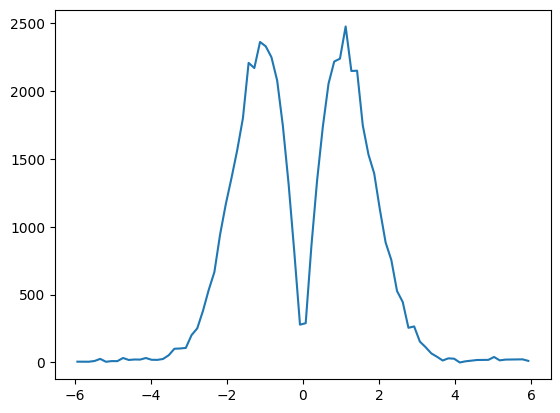

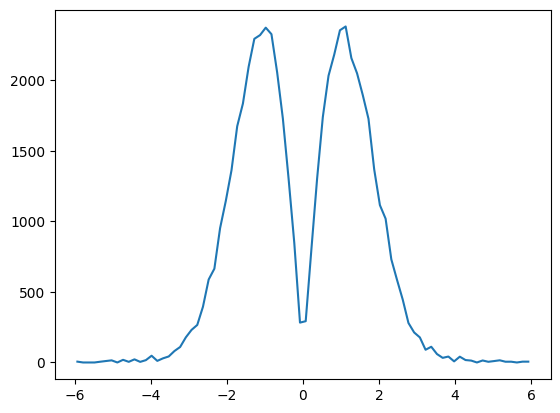

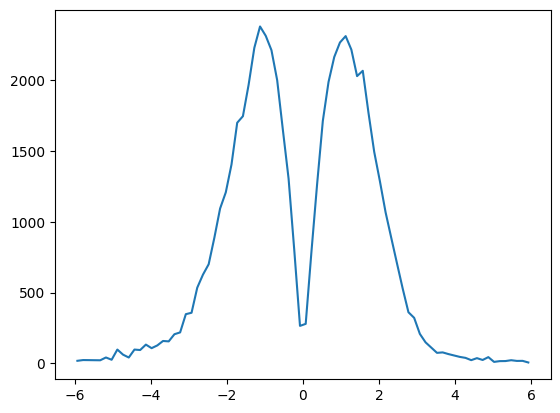

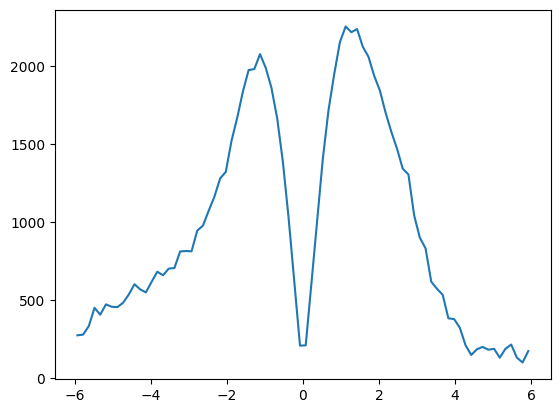

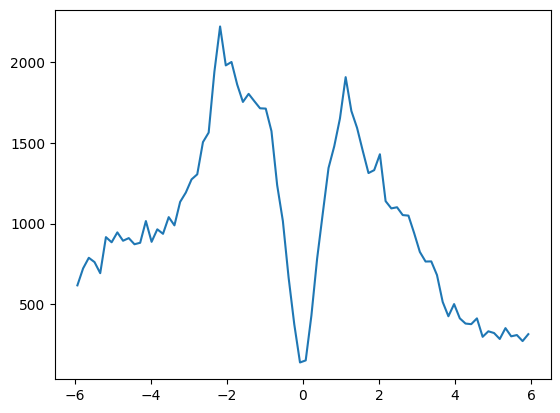

In [64]:
for i in range(NSCALES):
    plt.plot(
        l1_bins_np[i], l1_norms_np[i], label=f"Scale {i+1}"
    )
    plt.show()
# plt.xlim(-5.9,5.9)
# plt.ylim(0,2500)

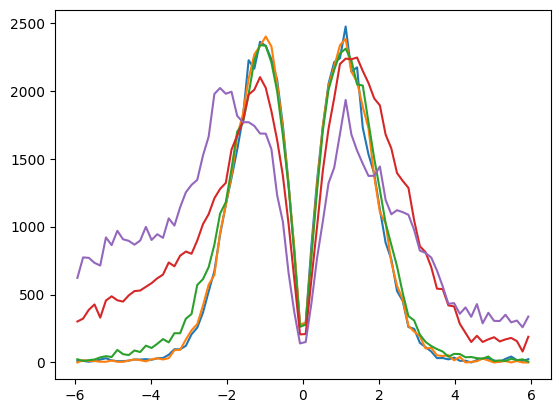

In [65]:
for i in range(NSCALES):
    plt.plot(l1_bins_np[i], l1norm[i])

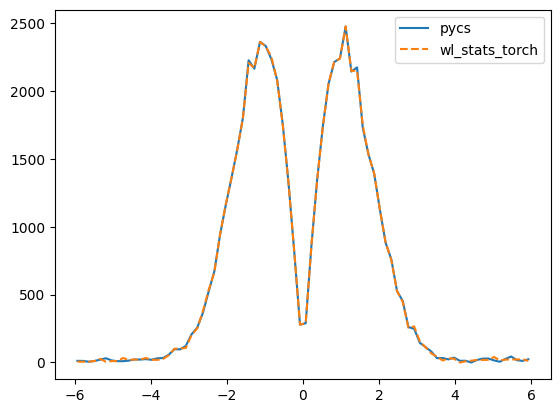

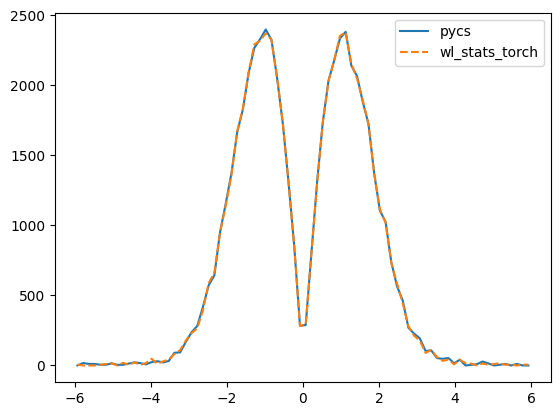

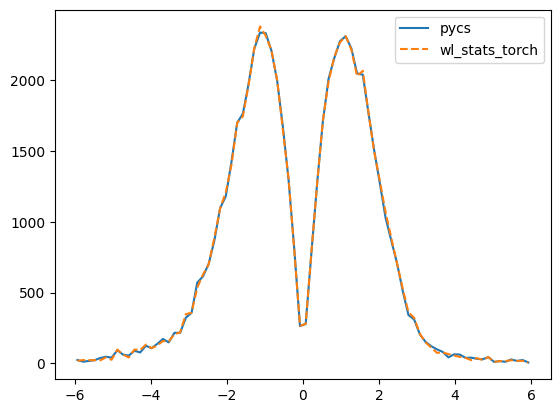

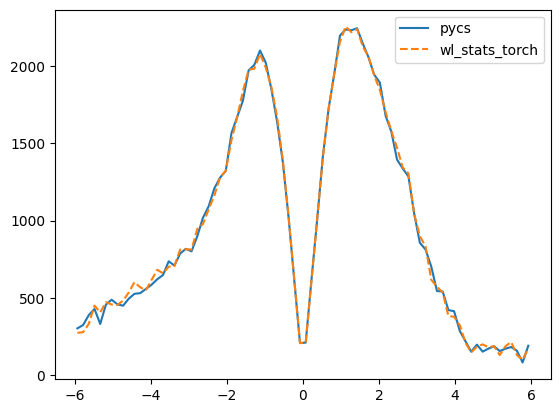

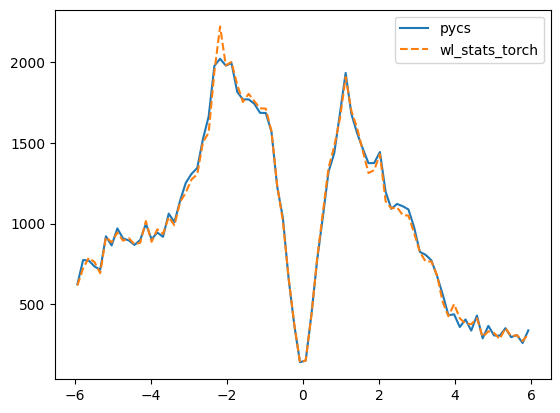

In [66]:
for i in range(NSCALES):
    plt.plot(l1_bins_np[i], l1norm[i], label=f"pycs")
    plt.plot(l1_bins_np[i], l1_norms_np[i], label=f"wl_stats_torch", linestyle='dashed')
    plt.legend()
    plt.show()